## Importing Libraries

In [1]:
import pickle
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

%matplotlib inline

## Getting the Data

In [2]:
data = pd.read_csv('train-data.csv')
print(data.shape)
data.head()

(6019, 14)


,Unnamed: 0,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Price
0,0,Maruti Wagon R LXI CNG,Mumbai,2010,72000,CNG,Manual,First,26.6 km/kg,998 CC,58.16 bhp,5.0,NaN,1.75
1,1,Hyundai Creta 1.6 CRDi SX Option,Pune,2015,41000,Diesel,Manual,First,19.67 kmpl,1582 CC,126.2 bhp,5.0,NaN,12.50
2,2,Honda Jazz V,Chennai,2011,46000,Petrol,Manual,First,18.2 kmpl,1199 CC,88.7 bhp,5.0,8.61 Lakh,4.50
3,3,Maruti Ertiga VDI,Chennai,2012,87000,Diesel,Manual,First,20.77 kmpl,1248 CC,88.76 bhp,7.0,NaN,6.00
4,4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,2013,40670,Diesel,Automatic,Second,15.2 kmpl,1968 CC,140.8 bhp,5.0,NaN,17.74


## Exploring and Cleaning the Data

**Removing Unnecessary columns**

In [3]:
data['New_Price'].count()

824

In [4]:
# Since New_Price has so many NaN values, we drop it along with the Unnamed column
data.drop(['Unnamed: 0', 'New_Price'], axis = 1, inplace = True)

**Removing the Units**

In [5]:
data.loc[:, 'Mileage'] = data['Mileage'].str.split().str.get(0)
data.loc[:, 'Engine'] = data['Engine'].str.split().str.get(0)
data.loc[:, 'Power'] = data['Power'].str.split().str.get(0)

**Extracting only the Company's Name**

In [6]:
data.loc[:, 'Name'] = data['Name'].str.split().str.get(0)

data.head()

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Price
0,Maruti,Mumbai,2010,72000,CNG,Manual,First,26.6,998,58.16,5.0,1.75
1,Hyundai,Pune,2015,41000,Diesel,Manual,First,19.67,1582,126.2,5.0,12.50
2,Honda,Chennai,2011,46000,Petrol,Manual,First,18.2,1199,88.7,5.0,4.50
3,Maruti,Chennai,2012,87000,Diesel,Manual,First,20.77,1248,88.76,7.0,6.00
4,Audi,Coimbatore,2013,40670,Diesel,Automatic,Second,15.2,1968,140.8,5.0,17.74


**Finding NA values in the dataframe**

In [7]:
data.count()

Name                 6019
Location             6019
Year                 6019
Kilometers_Driven    6019
Fuel_Type            6019
Transmission         6019
Owner_Type           6019
Mileage              6017
Engine               5983
Power                5983
Seats                5977
Price                6019
dtype: int64

In [8]:
data[(data['Mileage'].isna()) | (data['Mileage'] == "null")]

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Price
4446,Mahindra,Chennai,2016,50000,Electric,Automatic,First,NaN,72,41,5.0,13.00
4904,Toyota,Mumbai,2011,44000,Electric,Automatic,First,NaN,1798,73,5.0,12.75


In [9]:
data[(data['Engine'].isna()) | (data['Engine'] == "null")]

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Price
194,Honda,Ahmedabad,2007,60006,Petrol,Manual,First,0.0,NaN,NaN,NaN,2.95
208,Maruti,Kolkata,2010,42001,Petrol,Manual,First,16.1,NaN,NaN,NaN,2.11
733,Maruti,Chennai,2006,97800,Petrol,Manual,Third,16.1,NaN,NaN,NaN,1.75
749,Land,Mumbai,2008,55001,Diesel,Automatic,Second,0.0,NaN,NaN,NaN,26.50
1294,Honda,Delhi,2009,55005,Petrol,Manual,First,12.8,NaN,NaN,NaN,3.20
1327,Maruti,Hyderabad,2015,50295,Petrol,Manual,First,16.1,NaN,NaN,NaN,5.80
1385,Honda,Pune,2004,115000,Petrol,Manual,Second,0.0,NaN,NaN,NaN,1.50
1460,Land,Coimbatore,2008,69078,Petrol,Manual,First,0.0,NaN,NaN,NaN,40.88
2074,Maruti,Pune,2011,24255,Petrol,Manual,First,16.1,NaN,NaN,NaN,3.15
2096,Hyundai,Coimbatore,2004,52146,Petrol,Manual,First,0.0,NaN,NaN,NaN,1.93


In [10]:
data[(data['Power'].isna()) | (data['Power'] == "null")].sample(40, axis = 0)

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Price
1388,Maruti,Pune,2013,37000,Diesel,Manual,First,17.8,1248,null,5.0,4.85
2369,Maruti,Chennai,2008,56000,Petrol,Manual,Second,19.5,1061,null,NaN,1.50
3033,Hyundai,Jaipur,2005,120000,Petrol,Manual,First,0.0,1086,null,5.0,1.15
76,Ford,Jaipur,2008,111111,Diesel,Manual,First,17.8,1399,null,5.0,2.00
5458,Maruti,Hyderabad,2014,81609,Diesel,Manual,First,17.8,1248,null,5.0,5.55
227,Maruti,Delhi,2013,47000,Diesel,Manual,First,17.8,1248,null,5.0,4.10
5533,Hyundai,Pune,2007,72000,Petrol,Manual,Second,17.0,1086,null,5.0,1.11
1327,Maruti,Hyderabad,2015,50295,Petrol,Manual,First,16.1,NaN,NaN,NaN,5.80
2267,Toyota,Pune,2004,215750,Diesel,Manual,Second,0.0,2446,null,10.0,3.50
749,Land,Mumbai,2008,55001,Diesel,Automatic,Second,0.0,NaN,NaN,NaN,26.50


In [11]:
data[(data['Seats'].isna()) | (data['Seats'] == "null")]

C:\Users\RAJDEEP\Anaconda\Anaconda3\envs\deadeye\lib\site-packages\pandas\core\ops\array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Price
194,Honda,Ahmedabad,2007,60006,Petrol,Manual,First,0.0,NaN,NaN,NaN,2.95
208,Maruti,Kolkata,2010,42001,Petrol,Manual,First,16.1,NaN,NaN,NaN,2.11
229,Ford,Bangalore,2015,70436,Diesel,Manual,First,0.0,1498,99,NaN,3.60
733,Maruti,Chennai,2006,97800,Petrol,Manual,Third,16.1,NaN,NaN,NaN,1.75
749,Land,Mumbai,2008,55001,Diesel,Automatic,Second,0.0,NaN,NaN,NaN,26.50
1294,Honda,Delhi,2009,55005,Petrol,Manual,First,12.8,NaN,NaN,NaN,3.20
1327,Maruti,Hyderabad,2015,50295,Petrol,Manual,First,16.1,NaN,NaN,NaN,5.80
1385,Honda,Pune,2004,115000,Petrol,Manual,Second,0.0,NaN,NaN,NaN,1.50
1460,Land,Coimbatore,2008,69078,Petrol,Manual,First,0.0,NaN,NaN,NaN,40.88
1917,Honda,Jaipur,2005,88000,Petrol,Manual,Second,13.0,1493,100,NaN,1.70


Clearly, `Mileage`, `Engine`, `Power` and `Seats` have some `NaN` values. Also, Power seems to have `null` values along with this. 

**Checking DataType of Columns**

In [12]:
for i in data:
    print("{0} :".format(i), type(data[i][0]))

Name : <class 'str'>
Location : <class 'str'>
Year : <class 'numpy.int64'>
Kilometers_Driven : <class 'numpy.int64'>
Fuel_Type : <class 'str'>
Transmission : <class 'str'>
Owner_Type : <class 'str'>
Mileage : <class 'str'>
Engine : <class 'str'>
Power : <class 'str'>
Seats : <class 'numpy.float64'>
Price : <class 'numpy.float64'>


Here, we see that `Mileage`, `Engine` and `Power` have `str` type even though they only contain `float`/`int` values.

**Converting DataType of Columns**

In [13]:
data.loc[:, 'Mileage'] = data['Mileage'].astype(float)

In [14]:
data.loc[:, 'Engine'] = data['Engine'].astype(float)

In [15]:
# Converting the 'null' values to NaNs first
data.loc[:, 'Power'][data['Power'] == "null"] = np.nan
data.loc[:, 'Power'] = data['Power'].astype(float)

<ipython-input-15-954209c29f80>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[:, 'Power'][data['Power'] == "null"] = np.nan


In [16]:
for i in data:
    print("{0} :".format(i), type(data[i][0]))

Name : <class 'str'>
Location : <class 'str'>
Year : <class 'numpy.int64'>
Kilometers_Driven : <class 'numpy.int64'>
Fuel_Type : <class 'str'>
Transmission : <class 'str'>
Owner_Type : <class 'str'>
Mileage : <class 'numpy.float64'>
Engine : <class 'numpy.float64'>
Power : <class 'numpy.float64'>
Seats : <class 'numpy.float64'>
Price : <class 'numpy.float64'>


**Filling these Null Values**

In [17]:
data.count()

Name                 6019
Location             6019
Year                 6019
Kilometers_Driven    6019
Fuel_Type            6019
Transmission         6019
Owner_Type           6019
Mileage              6017
Engine               5983
Power                5876
Seats                5977
Price                6019
dtype: int64

In [18]:
print("MILEAGE MAX: ", np.nanmax(data['Mileage']))
print("MILEAGE MAX: ", np.nanmin(data['Mileage']))
print("MILEAGE MEAN: ", np.nanmean(data['Mileage']))
print("MILEAGE MEDIAN: ", np.nanmedian(data['Mileage']))
print("MILEAGE MODE: ", stats.mode(data['Mileage']))
print("MILEAGE STD: ", np.nanstd(data['Mileage']))

MILEAGE MAX:  33.54
MILEAGE MAX:  0.0
MILEAGE MEAN:  18.134960943992024
MILEAGE MEDIAN:  18.15
MILEAGE MODE:  ModeResult(mode=array([17.]), count=array([173]))
MILEAGE STD:  4.581908335833012


The `Standard deviation` is comparatively small for `Mileage`. Hence, we can use `Mean` to replace the missing values.

In [19]:
mileage_mean = np.nanmean(data['Mileage'])
data.loc[:, 'Mileage'][data['Mileage'].isna()] = mileage_mean

<ipython-input-19-d8fdb0821344>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[:, 'Mileage'][data['Mileage'].isna()] = mileage_mean


In [20]:
print("ENGINE MAX: ", np.nanmax(data['Engine']))
print("ENGINE MAX: ", np.nanmin(data['Engine']))
print("ENGINE MEAN: ", np.nanmean(data['Engine']))
print("ENGINE MEDIAN: ", np.nanmedian(data['Engine']))
print("ENGINE MODE: ", stats.mode(data['Engine']))
print("ENGINE STD: ", np.nanstd(data['Engine']))

ENGINE MAX:  5998.0
ENGINE MAX:  72.0
ENGINE MEAN:  1621.276449941501
ENGINE MEDIAN:  1493.0
ENGINE MODE:  ModeResult(mode=array([1197.]), count=array([606]))
ENGINE STD:  601.3049751992447


The `Standard deviation` is comparable to the `Mean` for `Engine` (probably because of presence of outliers). Hence, we can use `Median` to replace the missing values.

In [21]:
engine_median = np.nanmedian(data['Engine'])
data.loc[:, 'Engine'][data['Engine'].isna()] = engine_median

<ipython-input-21-3ddeb155dabe>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[:, 'Engine'][data['Engine'].isna()] = engine_median


In [22]:
print("POWER MAX: ", np.nanmax(data['Power']))
print("POWER MAX: ", np.nanmin(data['Power']))
print("POWER MEAN: ", np.nanmean(data['Power']))
print("POWER MEDIAN: ", np.nanmedian(data['Power']))
print("POWER MODE: ", stats.mode(data['Power']))
print("POWER STD: ", np.nanstd(data['Power']))

POWER MAX:  560.0
POWER MAX:  34.2
POWER MEAN:  113.25304969366915
POWER MEDIAN:  97.7
POWER MODE:  ModeResult(mode=array([74.]), count=array([235]))
POWER STD:  53.87037285523649


The `Standard deviation` is comparable to the `Mean` for `Power` (probably because of presence of outliers). Hence, we can use `Median` to replace the missing values.

In [23]:
power_median = np.nanmedian(data['Power'])
data.loc[:, 'Power'][data['Power'].isna()] = power_median

<ipython-input-23-d81b09c6a486>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[:, 'Power'][data['Power'].isna()] = power_median


In [24]:
print("SEATS MAX: ", np.nanmax(data['Seats']))
print("SEATS MAX: ", np.nanmin(data['Seats']))
print("SEATS MEAN: ", np.nanmean(data['Seats']))
print("SEATS MEDIAN: ", np.nanmedian(data['Seats']))
print("SEATS MODE: ", stats.mode(data['Seats']))
print("SEATS STD: ", np.nanstd(data['Seats']))

SEATS MAX:  10.0
SEATS MAX:  0.0
SEATS MEAN:  5.278735151413753
SEATS MEDIAN:  5.0
SEATS MODE:  ModeResult(mode=array([5.]), count=array([5014]))
SEATS STD:  0.8087718892481326


The `Standard deviation` is comparatively small for `Seats`. Hence, we can use `Mean` to replace the missing values.

In [25]:
seats_mean = np.nanmean(data['Seats'])
data.loc[:, 'Seats'][data['Seats'].isna()] = seats_mean

<ipython-input-25-12f33acc6529>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[:, 'Seats'][data['Seats'].isna()] = seats_mean


In [26]:
data.count()

Name                 6019
Location             6019
Year                 6019
Kilometers_Driven    6019
Fuel_Type            6019
Transmission         6019
Owner_Type           6019
Mileage              6019
Engine               6019
Power                6019
Seats                6019
Price                6019
dtype: int64

## Looking through the Distribution

**Name vs Price**

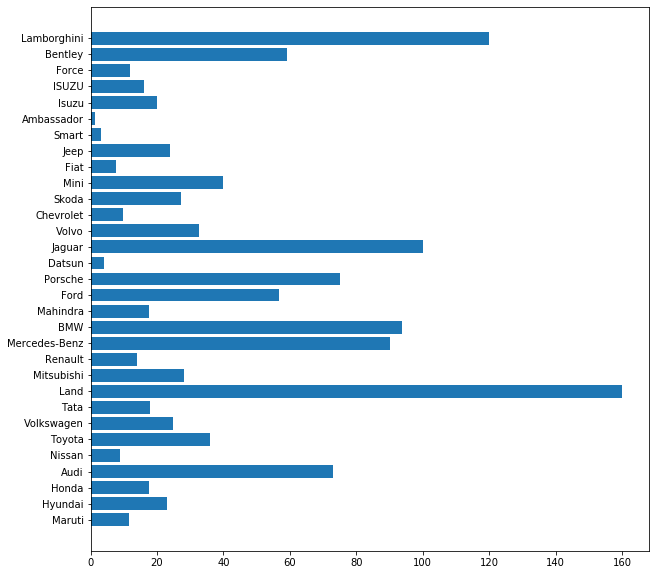

In [27]:
plt.figure(figsize = (10,10))
plt.barh(data["Name"], data['Price'])
plt.show()

**Location vs Price**

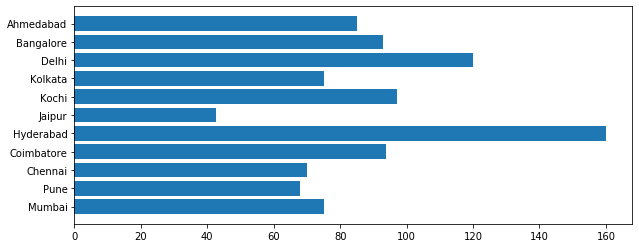

In [28]:
plt.figure(figsize = (10,4))
plt.barh(data["Location"], data['Price'])
plt.show()

**Year vs Price**

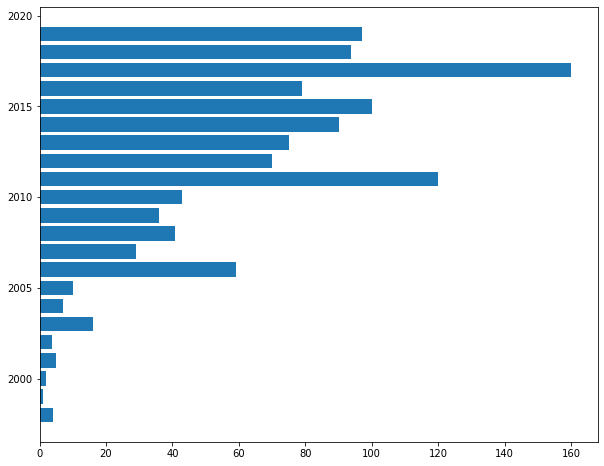

In [29]:
plt.figure(figsize = (10,8))
plt.barh(data["Year"], data['Price'])
plt.show()

**Kilometres_Driven vs Price**

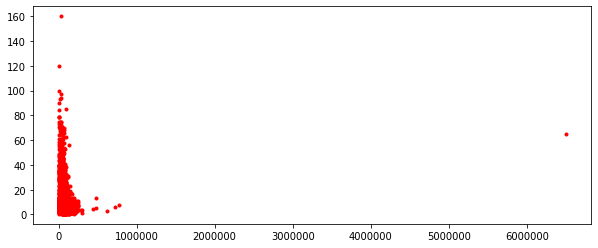

In [30]:
plt.figure(figsize = (10,4))
plt.plot(data['Kilometers_Driven'], data['Price'], 'r.')
plt.show()

In [31]:
# Clipping the Kilometres_Driven
data['Kilometers_Driven'].clip(upper = 200000, inplace = True)

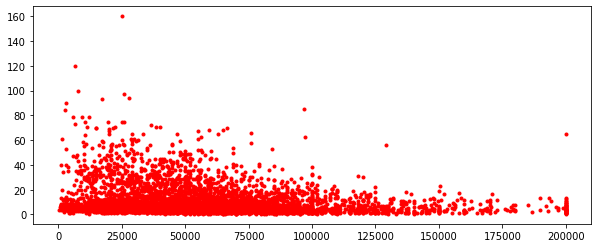

In [32]:
plt.figure(figsize = (10,4))
plt.plot(data['Kilometers_Driven'], data['Price'], 'r.')
plt.show()

**Fuel_Type vs Price**

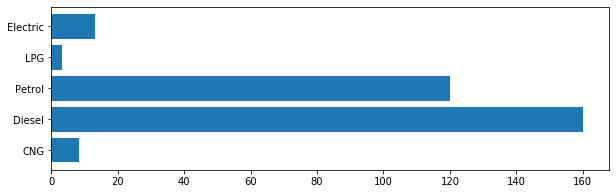

In [33]:
plt.figure(figsize = (10,3))
plt.barh(data["Fuel_Type"], data['Price'])
plt.show()

**Transmission vs Price**

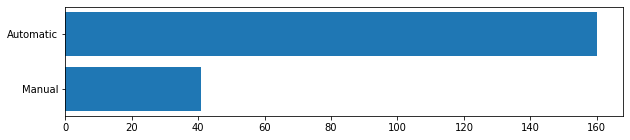

In [34]:
plt.figure(figsize = (10,2))
plt.barh(data["Transmission"], data['Price'])
plt.show()

**Owner_Type vs Price**

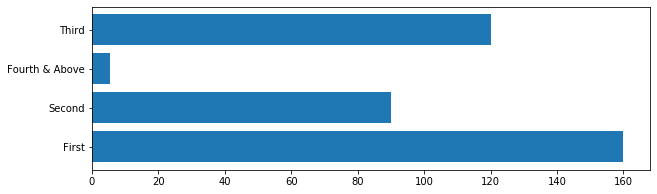

In [35]:
plt.figure(figsize = (10,3))
plt.barh(data["Owner_Type"], data['Price'])
plt.show()

**Mileage vs Price**

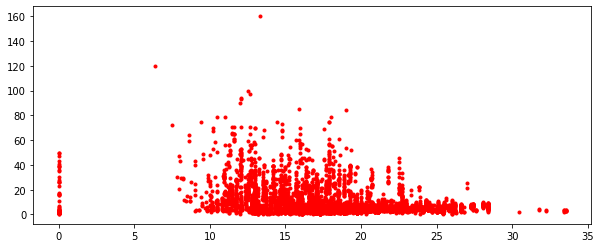

In [36]:
plt.figure(figsize = (10,4))
plt.plot(data['Mileage'], data['Price'], 'r.')
plt.show()

**Engine vs Price**

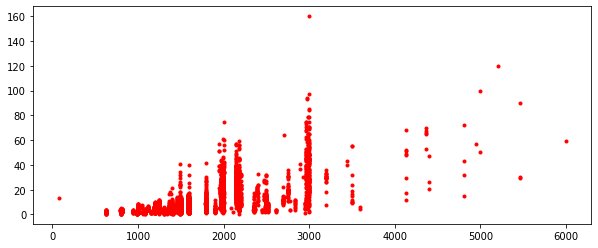

In [37]:
plt.figure(figsize = (10,4))
plt.plot(data['Engine'], data['Price'], 'r.')
plt.show()

**Power vs Price**

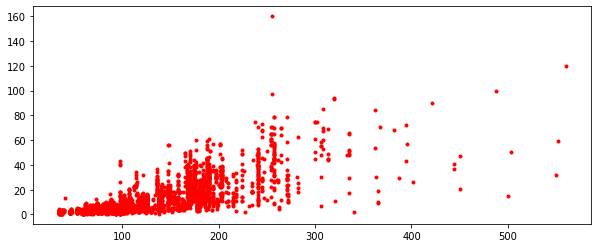

In [38]:
plt.figure(figsize = (10,4))
plt.plot(data['Power'], data['Price'], 'r.')
plt.show()

**Seats vs Price**

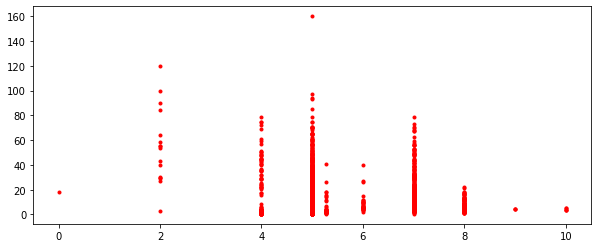

In [39]:
plt.figure(figsize = (10,4))
plt.plot(data['Seats'], data['Price'], 'r.')
plt.show()

## One Hot Encoding the Data

In [40]:
print(data.shape)
data.head()

(6019, 12)


,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Price
0,Maruti,Mumbai,2010,72000,CNG,Manual,First,26.60,998.0,58.16,5.0,1.75
1,Hyundai,Pune,2015,41000,Diesel,Manual,First,19.67,1582.0,126.20,5.0,12.50
2,Honda,Chennai,2011,46000,Petrol,Manual,First,18.20,1199.0,88.70,5.0,4.50
3,Maruti,Chennai,2012,87000,Diesel,Manual,First,20.77,1248.0,88.76,7.0,6.00
4,Audi,Coimbatore,2013,40670,Diesel,Automatic,Second,15.20,1968.0,140.80,5.0,17.74


In [41]:
data = pd.get_dummies(data)
print(data.shape)
data.head()

(6019, 60)


,Year,Kilometers_Driven,Mileage,Engine,Power,Seats,Price,Name_Ambassador,Name_Audi,Name_BMW,...,Fuel_Type_Diesel,Fuel_Type_Electric,Fuel_Type_LPG,Fuel_Type_Petrol,Transmission_Automatic,Transmission_Manual,Owner_Type_First,Owner_Type_Fourth & Above,Owner_Type_Second,Owner_Type_Third
0,2010,72000,26.60,998.0,58.16,5.0,1.75,0,0,0,...,0,0,0,0,0,1,1,0,0,0
1,2015,41000,19.67,1582.0,126.20,5.0,12.50,0,0,0,...,1,0,0,0,0,1,1,0,0,0
2,2011,46000,18.20,1199.0,88.70,5.0,4.50,0,0,0,...,0,0,0,1,0,1,1,0,0,0
3,2012,87000,20.77,1248.0,88.76,7.0,6.00,0,0,0,...,1,0,0,0,0,1,1,0,0,0
4,2013,40670,15.20,1968.0,140.80,5.0,17.74,0,1,0,...,1,0,0,0,1,0,0,0,1,0


In [42]:
print(data.columns)

Index(['Year', 'Kilometers_Driven', 'Mileage', 'Engine', 'Power', 'Seats',
       'Price', 'Name_Ambassador', 'Name_Audi', 'Name_BMW', 'Name_Bentley',
       'Name_Chevrolet', 'Name_Datsun', 'Name_Fiat', 'Name_Force', 'Name_Ford',
       'Name_Honda', 'Name_Hyundai', 'Name_ISUZU', 'Name_Isuzu', 'Name_Jaguar',
       'Name_Jeep', 'Name_Lamborghini', 'Name_Land', 'Name_Mahindra',
       'Name_Maruti', 'Name_Mercedes-Benz', 'Name_Mini', 'Name_Mitsubishi',
       'Name_Nissan', 'Name_Porsche', 'Name_Renault', 'Name_Skoda',
       'Name_Smart', 'Name_Tata', 'Name_Toyota', 'Name_Volkswagen',
       'Name_Volvo', 'Location_Ahmedabad', 'Location_Bangalore',
       'Location_Chennai', 'Location_Coimbatore', 'Location_Delhi',
       'Location_Hyderabad', 'Location_Jaipur', 'Location_Kochi',
       'Location_Kolkata', 'Location_Mumbai', 'Location_Pune', 'Fuel_Type_CNG',
       'Fuel_Type_Diesel', 'Fuel_Type_Electric', 'Fuel_Type_LPG',
       'Fuel_Type_Petrol', 'Transmission_Automatic', 'Transmis

## Input Features and Target Values

In [43]:
X = data.drop("Price", axis = 1)
X.head()

,Year,Kilometers_Driven,Mileage,Engine,Power,Seats,Name_Ambassador,Name_Audi,Name_BMW,Name_Bentley,...,Fuel_Type_Diesel,Fuel_Type_Electric,Fuel_Type_LPG,Fuel_Type_Petrol,Transmission_Automatic,Transmission_Manual,Owner_Type_First,Owner_Type_Fourth & Above,Owner_Type_Second,Owner_Type_Third
0,2010,72000,26.60,998.0,58.16,5.0,0,0,0,0,...,0,0,0,0,0,1,1,0,0,0
1,2015,41000,19.67,1582.0,126.20,5.0,0,0,0,0,...,1,0,0,0,0,1,1,0,0,0
2,2011,46000,18.20,1199.0,88.70,5.0,0,0,0,0,...,0,0,0,1,0,1,1,0,0,0
3,2012,87000,20.77,1248.0,88.76,7.0,0,0,0,0,...,1,0,0,0,0,1,1,0,0,0
4,2013,40670,15.20,1968.0,140.80,5.0,0,1,0,0,...,1,0,0,0,1,0,0,0,1,0


In [44]:
Y = data['Price']
Y.head()

0     1.75
1    12.50
2     4.50
3     6.00
4    17.74
Name: Price, dtype: float64

## Training Models

**Random Forest**

In [45]:
rfr = RandomForestRegressor(random_state = 42, criterion = 'mse', n_jobs = -1)
rfr_params = dict(n_estimators = [50, 100, 150],
                  max_depth = [None, 2, 3, 4],
                  min_samples_split = [n for n in range(2, 5)],
                  min_samples_leaf = [n for n in range(1, 4)],
                  oob_score = [False, True],
                  max_samples = [None, 0.5, 0.9])

In [46]:
rfr_cv = GridSearchCV(estimator = rfr, param_grid = rfr_params, n_jobs = -1, cv = 5)
rfr_cv.fit(X, Y);

In [47]:
print("Best score: {}".format(rfr_cv.best_score_))
print("Optimal params: {}".format(rfr_cv.best_estimator_))

Best score: 0.8873365466303949
Optimal params: RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=0.9, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=150, n_jobs=-1, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)


**Gradient Boosting Regressor**

In [48]:
gbr = GradientBoostingRegressor(random_state = 42, loss = 'ls', criterion = 'friedman_mse')
gbr_params = dict(learning_rate = [0.01, 0.1, 0.5],
                  n_estimators = [50, 100, 150],
                  subsample = [0.75, 1.0, 1.25],
                  min_samples_split = [n for n in range(2, 5)],
                  min_samples_leaf = [n for n in range(1, 4)],
                  max_depth = [n for n in range(2,8)])

In [49]:
gbr_cv = GridSearchCV(estimator = gbr, param_grid = gbr_params, n_jobs = -1, cv = 5)
gbr_cv.fit(X,Y);

In [50]:
print("Best score: {}".format(gbr_cv.best_score_))
print("Optimal params: {}".format(gbr_cv.best_estimator_))

Best score: 0.9075027314824785
Optimal params: GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.5, loss='ls', max_depth=4,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=4,
                          min_weight_fraction_leaf=0.0, n_estimators=150,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=42, subsample=0.75, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)


**XGBoost Regressor**

In [51]:
xgbr = XGBRegressor(random_state = 42, n_jobs = -1, objective = 'reg:squarederror')
xgbr_params = dict(n_estimators = [50, 100, 150],
                   max_depth = [None, 2, 3, 4, 5, 6],
                   learning_rate = [0.01, 0.1, 0.5],
                   subsample = [0.75, 1, 1.25],
                   colsample_bytree = [0.3, 0.5],
                   reg_alpha = [0.1, 1],
                   reg_lambda = [0.1, 1])

In [52]:
xgbr_cv = GridSearchCV(estimator = xgbr, param_grid = xgbr_params, n_jobs = -1, cv = 5)
xgbr_cv.fit(X,Y);

In [53]:
print("Best score: {}".format(xgbr_cv.best_score_))
print("Optimal params: {}".format(xgbr_cv.best_estimator_))

Best score: 0.9029516836392281
Optimal params: XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.5, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.1, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=150, n_jobs=-1, num_parallel_tree=1,
             objective='reg:squarederror', random_state=42, reg_alpha=1,
             reg_lambda=0.1, scale_pos_weight=1, subsample=0.75,
             tree_method=None, validate_parameters=False, verbosity=None)


## Choosing and Saving the Best Model

**Saving**

In [54]:
# Among the above models, we see that Gradient Boosting Regressor performed the best.
model = gbr_cv.best_estimator_

In [55]:
pkl_filename = "final_model.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(model, file)

**Loading**

In [56]:
with open(pkl_filename, 'rb') as file:
    model = pickle.load(file)

## Getting the Test Data

In [57]:
X_test = pd.read_csv("test-data.csv")
print(X_test.shape)
X_test.head()

(1234, 13)


,Unnamed: 0,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price
0,0,Maruti Alto K10 LXI CNG,Delhi,2014,40929,CNG,Manual,First,32.26 km/kg,998 CC,58.2 bhp,4.0,NaN
1,1,Maruti Alto 800 2016-2019 LXI,Coimbatore,2013,54493,Petrol,Manual,Second,24.7 kmpl,796 CC,47.3 bhp,5.0,NaN
2,2,Toyota Innova Crysta Touring Sport 2.4 MT,Mumbai,2017,34000,Diesel,Manual,First,13.68 kmpl,2393 CC,147.8 bhp,7.0,25.27 Lakh
3,3,Toyota Etios Liva GD,Hyderabad,2012,139000,Diesel,Manual,First,23.59 kmpl,1364 CC,null bhp,5.0,NaN
4,4,Hyundai i20 Magna,Mumbai,2014,29000,Petrol,Manual,First,18.5 kmpl,1197 CC,82.85 bhp,5.0,NaN


## Cleaning the Test Data

**Removing the Unncessary columns**

In [58]:
X_test.drop(['Unnamed: 0', 'New_Price'], axis = 1, inplace = True)

**Removing the Units**

In [59]:
X_test.loc[:, 'Mileage'] = X_test['Mileage'].str.split().str.get(0)
X_test.loc[:, 'Engine'] = X_test['Engine'].str.split().str.get(0)
X_test.loc[:, 'Power'] = X_test['Power'].str.split().str.get(0)

**Extracting only the Company's Name**

In [60]:
X_test.loc[:, 'Name'] = X_test['Name'].str.split().str.get(0)

X_test.head()

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats
0,Maruti,Delhi,2014,40929,CNG,Manual,First,32.26,998,58.2,4.0
1,Maruti,Coimbatore,2013,54493,Petrol,Manual,Second,24.7,796,47.3,5.0
2,Toyota,Mumbai,2017,34000,Diesel,Manual,First,13.68,2393,147.8,7.0
3,Toyota,Hyderabad,2012,139000,Diesel,Manual,First,23.59,1364,null,5.0
4,Hyundai,Mumbai,2014,29000,Petrol,Manual,First,18.5,1197,82.85,5.0


**Finding NA values in the test data**

In [61]:
X_test.count()

Name                 1234
Location             1234
Year                 1234
Kilometers_Driven    1234
Fuel_Type            1234
Transmission         1234
Owner_Type           1234
Mileage              1234
Engine               1224
Power                1224
Seats                1223
dtype: int64

In [62]:
X_test[(X_test['Engine'].isna()) | (X_test['Engine'] == "null")]

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats
23,Skoda,Bangalore,2009,72000,Petrol,Manual,Second,17.5,NaN,NaN,NaN
522,Toyota,Bangalore,2012,56600,Diesel,Manual,First,23.59,NaN,NaN,NaN
525,Hyundai,Bangalore,2012,58000,Petrol,Automatic,Second,15.0,NaN,NaN,NaN
614,Mahindra,Kolkata,2016,27000,Diesel,Manual,First,0.0,NaN,NaN,NaN
624,BMW,Bangalore,2009,150000,Diesel,Automatic,Second,18.48,NaN,NaN,NaN
632,Maruti,Kolkata,2015,36009,Petrol,Manual,First,16.1,NaN,NaN,NaN
658,Fiat,Jaipur,2010,65000,Petrol,Manual,Third,14.6,NaN,NaN,NaN
666,Maruti,Pune,2010,115000,Petrol,Manual,Second,16.1,NaN,NaN,NaN
861,BMW,Chennai,2009,95000,Diesel,Automatic,Second,18.48,NaN,NaN,NaN
883,Toyota,Kochi,2012,59311,Petrol,Manual,First,18.3,NaN,NaN,NaN


In [63]:
X_test[(X_test['Power'].isna()) | (X_test['Power'] == "null")]

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats
3,Toyota,Hyderabad,2012,139000,Diesel,Manual,First,23.59,1364,null,5.0
23,Skoda,Bangalore,2009,72000,Petrol,Manual,Second,17.5,NaN,NaN,NaN
74,Hyundai,Bangalore,2007,47000,Petrol,Manual,Second,0.0,1086,null,5.0
122,Toyota,Jaipur,2012,121134,Diesel,Manual,First,23.59,1364,null,5.0
143,Ford,Jaipur,2008,135000,Diesel,Manual,First,17.8,1399,null,5.0
191,Tata,Chennai,2006,140000,Diesel,Manual,Second,13.5,1405,null,5.0
197,Hindustan,Pune,1996,65000,Diesel,Manual,Second,14.1,1995,null,5.0
259,Toyota,Bangalore,2012,90000,Diesel,Manual,First,23.59,1364,null,5.0
367,Nissan,Coimbatore,2009,67038,Petrol,Automatic,First,9.1,2349,null,5.0
409,Nissan,Chennai,2008,63288,Petrol,Automatic,First,9.1,2349,null,5.0


In [64]:
X_test[(X_test['Seats'].isna()) | (X_test['Seats'] == "null")]

C:\Users\RAJDEEP\Anaconda\Anaconda3\envs\deadeye\lib\site-packages\pandas\core\ops\array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats
23,Skoda,Bangalore,2009,72000,Petrol,Manual,Second,17.5,NaN,NaN,NaN
522,Toyota,Bangalore,2012,56600,Diesel,Manual,First,23.59,NaN,NaN,NaN
525,Hyundai,Bangalore,2012,58000,Petrol,Automatic,Second,15.0,NaN,NaN,NaN
614,Mahindra,Kolkata,2016,27000,Diesel,Manual,First,0.0,NaN,NaN,NaN
624,BMW,Bangalore,2009,150000,Diesel,Automatic,Second,18.48,NaN,NaN,NaN
632,Maruti,Kolkata,2015,36009,Petrol,Manual,First,16.1,NaN,NaN,NaN
658,Fiat,Jaipur,2010,65000,Petrol,Manual,Third,14.6,NaN,NaN,NaN
666,Maruti,Pune,2010,115000,Petrol,Manual,Second,16.1,NaN,NaN,NaN
861,BMW,Chennai,2009,95000,Diesel,Automatic,Second,18.48,NaN,NaN,NaN
883,Toyota,Kochi,2012,59311,Petrol,Manual,First,18.3,NaN,NaN,NaN


Clearly, `Engine`, `Power` and `Seats` have some `NaN`/`null` values.

**Checking DataType of Columns**

In [65]:
for i in X_test:
    print("{0} :".format(i), type(X_test[i][0]))

Name : <class 'str'>
Location : <class 'str'>
Year : <class 'numpy.int64'>
Kilometers_Driven : <class 'numpy.int64'>
Fuel_Type : <class 'str'>
Transmission : <class 'str'>
Owner_Type : <class 'str'>
Mileage : <class 'str'>
Engine : <class 'str'>
Power : <class 'str'>
Seats : <class 'numpy.float64'>


Here, we see that `Mileage`, `Engine` and `Power` have `str` type even though they only contain `float`/`int` values.

**Converting DataType of Columns**

In [66]:
X_test.loc[:, 'Mileage'] = X_test['Mileage'].astype(float)

In [67]:
X_test.loc[:, 'Engine'] = X_test['Engine'].astype(float)

In [68]:
# Converting the 'null' values to NaNs first
X_test.loc[:, 'Power'][X_test['Power'] == "null"] = np.nan
X_test.loc[:, 'Power'] = X_test['Power'].astype(float)

<ipython-input-68-bc196c57575a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test.loc[:, 'Power'][X_test['Power'] == "null"] = np.nan


In [69]:
for i in X_test:
    print("{0} :".format(i), type(X_test[i][0]))

Name : <class 'str'>
Location : <class 'str'>
Year : <class 'numpy.int64'>
Kilometers_Driven : <class 'numpy.int64'>
Fuel_Type : <class 'str'>
Transmission : <class 'str'>
Owner_Type : <class 'str'>
Mileage : <class 'numpy.float64'>
Engine : <class 'numpy.float64'>
Power : <class 'numpy.float64'>
Seats : <class 'numpy.float64'>


**Filling these Null Values**

In [70]:
X_test.count()

Name                 1234
Location             1234
Year                 1234
Kilometers_Driven    1234
Fuel_Type            1234
Transmission         1234
Owner_Type           1234
Mileage              1234
Engine               1224
Power                1202
Seats                1223
dtype: int64

In [71]:
X_test.loc[:, 'Engine'][X_test['Engine'].isna()] = engine_median

<ipython-input-71-50cd036d0b34>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test.loc[:, 'Engine'][X_test['Engine'].isna()] = engine_median


In [72]:
X_test.loc[:, 'Power'][X_test['Power'].isna()] = power_median

<ipython-input-72-114bd2828156>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test.loc[:, 'Power'][X_test['Power'].isna()] = power_median


In [73]:
X_test.loc[:, 'Seats'][X_test['Seats'].isna()] = seats_mean

<ipython-input-73-944da7f05a61>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test.loc[:, 'Seats'][X_test['Seats'].isna()] = seats_mean


In [74]:
X_test.count()

Name                 1234
Location             1234
Year                 1234
Kilometers_Driven    1234
Fuel_Type            1234
Transmission         1234
Owner_Type           1234
Mileage              1234
Engine               1234
Power                1234
Seats                1234
dtype: int64

## One Hot Encoding the Test Data

In [75]:
print(X_test.shape)
X_test.head()

(1234, 11)


,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats
0,Maruti,Delhi,2014,40929,CNG,Manual,First,32.26,998.0,58.20,4.0
1,Maruti,Coimbatore,2013,54493,Petrol,Manual,Second,24.70,796.0,47.30,5.0
2,Toyota,Mumbai,2017,34000,Diesel,Manual,First,13.68,2393.0,147.80,7.0
3,Toyota,Hyderabad,2012,139000,Diesel,Manual,First,23.59,1364.0,97.70,5.0
4,Hyundai,Mumbai,2014,29000,Petrol,Manual,First,18.50,1197.0,82.85,5.0


In [76]:
X_test = pd.get_dummies(X_test)
print(X_test.shape)
X_test.head()

(1234, 56)


,Year,Kilometers_Driven,Mileage,Engine,Power,Seats,Name_Audi,Name_BMW,Name_Bentley,Name_Chevrolet,...,Fuel_Type_CNG,Fuel_Type_Diesel,Fuel_Type_LPG,Fuel_Type_Petrol,Transmission_Automatic,Transmission_Manual,Owner_Type_First,Owner_Type_Fourth & Above,Owner_Type_Second,Owner_Type_Third
0,2014,40929,32.26,998.0,58.20,4.0,0,0,0,0,...,1,0,0,0,0,1,1,0,0,0
1,2013,54493,24.70,796.0,47.30,5.0,0,0,0,0,...,0,0,0,1,0,1,0,0,1,0
2,2017,34000,13.68,2393.0,147.80,7.0,0,0,0,0,...,0,1,0,0,0,1,1,0,0,0
3,2012,139000,23.59,1364.0,97.70,5.0,0,0,0,0,...,0,1,0,0,0,1,1,0,0,0
4,2014,29000,18.50,1197.0,82.85,5.0,0,0,0,0,...,0,0,0,1,0,1,1,0,0,0


**Matching the columbs between Train and Test data**

In [77]:
test_cols = X_test.columns
train_cols = X.columns

In [78]:
train_not_test = []
for c in train_cols:
    if c not in  test_cols:
        train_not_test.append(c)

print("Columns present in Train Data but not in Test Data: ", train_not_test)

Columns present in Train Data but not in Test Data:  ['Name_Ambassador', 'Name_Force', 'Name_Lamborghini', 'Name_Smart', 'Fuel_Type_Electric']


In [79]:
test_not_train = []
for c in test_cols:
    if c not in  train_cols:
        test_not_train.append(c)
        
print("Columns present in Test Data but not in Train Data: ", test_not_train)           

Columns present in Test Data but not in Train Data:  ['Name_Hindustan', 'Name_OpelCorsa']


**Removing Columns present in Test Data but not in Train Data**

In [80]:
X_test.drop(test_not_train, axis = 1, inplace = True)

**Adding Columns present in Train Data but not in Test Data**

In [81]:
zeros = np.zeros(X_test.shape[0])
for c in train_not_test:
    X_test[c] = zeros

**Reordering the Test columns to match the Train columns**

In [82]:
X_test = X_test[X.columns]

In [83]:
print(X_test.shape)    
X_test.head()

(1234, 59)


,Year,Kilometers_Driven,Mileage,Engine,Power,Seats,Name_Ambassador,Name_Audi,Name_BMW,Name_Bentley,...,Fuel_Type_Diesel,Fuel_Type_Electric,Fuel_Type_LPG,Fuel_Type_Petrol,Transmission_Automatic,Transmission_Manual,Owner_Type_First,Owner_Type_Fourth & Above,Owner_Type_Second,Owner_Type_Third
0,2014,40929,32.26,998.0,58.20,4.0,0.0,0,0,0,...,0,0.0,0,0,0,1,1,0,0,0
1,2013,54493,24.70,796.0,47.30,5.0,0.0,0,0,0,...,0,0.0,0,1,0,1,0,0,1,0
2,2017,34000,13.68,2393.0,147.80,7.0,0.0,0,0,0,...,1,0.0,0,0,0,1,1,0,0,0
3,2012,139000,23.59,1364.0,97.70,5.0,0.0,0,0,0,...,1,0.0,0,0,0,1,1,0,0,0
4,2014,29000,18.50,1197.0,82.85,5.0,0.0,0,0,0,...,0,0.0,0,1,0,1,1,0,0,0


In [84]:
X_test.columns

Index(['Year', 'Kilometers_Driven', 'Mileage', 'Engine', 'Power', 'Seats',
       'Name_Ambassador', 'Name_Audi', 'Name_BMW', 'Name_Bentley',
       'Name_Chevrolet', 'Name_Datsun', 'Name_Fiat', 'Name_Force', 'Name_Ford',
       'Name_Honda', 'Name_Hyundai', 'Name_ISUZU', 'Name_Isuzu', 'Name_Jaguar',
       'Name_Jeep', 'Name_Lamborghini', 'Name_Land', 'Name_Mahindra',
       'Name_Maruti', 'Name_Mercedes-Benz', 'Name_Mini', 'Name_Mitsubishi',
       'Name_Nissan', 'Name_Porsche', 'Name_Renault', 'Name_Skoda',
       'Name_Smart', 'Name_Tata', 'Name_Toyota', 'Name_Volkswagen',
       'Name_Volvo', 'Location_Ahmedabad', 'Location_Bangalore',
       'Location_Chennai', 'Location_Coimbatore', 'Location_Delhi',
       'Location_Hyderabad', 'Location_Jaipur', 'Location_Kochi',
       'Location_Kolkata', 'Location_Mumbai', 'Location_Pune', 'Fuel_Type_CNG',
       'Fuel_Type_Diesel', 'Fuel_Type_Electric', 'Fuel_Type_LPG',
       'Fuel_Type_Petrol', 'Transmission_Automatic', 'Transmission_Manu

## Performing Inference

In [85]:
preds = model.predict(X_test)
print(len(preds))
preds

1234


array([ 3.07401121,  3.00982826, 16.15161013, ...,  2.63775075,
        3.48598894, 17.34933326])

## Creating Output CSV

In [86]:
ids = np.arange(0, 1234)

In [87]:
pd.DataFrame({'Id': ids,'Price': preds}).to_csv('output.csv',index = False)